In [1]:
import os
import sys
os.environ['QT_QPA_PLATFORM'] = 'offscreen'

from osgeo import ogr
from qgis.core import *
from qgis.gui import *
from qgis import processing

from qgis.PyQt.QtGui import QColor, QImage
from qgis.PyQt.QtCore import QSize, QBuffer, QIODevice

qgs = QgsApplication([], False)
qgs.initQgis()
print(QgsApplication.showSettings())

Application state:
QGIS_PREFIX_PATH env var:		C:/OSGEO4~1/apps/qgis
Prefix:		C:/OSGEO4~1/apps/qgis
Plugin Path:		C:/OSGEO4~1/apps/qgis/plugins
Package Data Path:	C:/OSGEO4~1/apps/qgis/.
Active Theme Name:	
Active Theme Path:	C:/OSGEO4~1/apps/qgis/./resources/themes\\icons/
Default Theme Path:	:/images/themes/default/
SVG Search Paths:	C:/OSGEO4~1/apps/qgis/./svg/
		C:/Users/bruno/AppData/Roaming/python3\profiles\default/svg/
User DB Path:	C:/OSGEO4~1/apps/qgis/./resources/qgis.db
Auth DB Path:	C:/Users/bruno/AppData/Roaming/python3\profiles\default/qgis-auth.db



# Buscar dados

Como o csv não está ordenado, é necessário ordená-lo e redefinir os índices da dataframe.

In [2]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/jgrocha/covid-pt/master/situacao_epidemiologica.csv")
df = df.sort_values(by=['id'])
df = df.set_index('id')

#df.tail()
pd.set_option('display.max_rows', df.shape[0]+1)
print(df)

                                                  url data_relatorio  \
id                                                                     
1   https://covid19.min-saude.pt/wp-content/upload...     2020-03-03   
2   https://covid19.min-saude.pt/wp-content/upload...     2020-03-04   
3   https://covid19.min-saude.pt/wp-content/upload...     2020-03-05   
4   https://covid19.min-saude.pt/wp-content/upload...     2020-03-06   
5   https://covid19.min-saude.pt/wp-content/upload...     2020-03-07   
6   https://covid19.min-saude.pt/wp-content/upload...     2020-03-08   
7   https://covid19.min-saude.pt/wp-content/upload...     2020-03-09   
8   https://covid19.min-saude.pt/wp-content/upload...     2020-03-10   
9   https://covid19.min-saude.pt/wp-content/upload...     2020-03-11   
10  https://covid19.min-saude.pt/wp-content/upload...     2020-03-12   
11  https://covid19.min-saude.pt/wp-content/upload...     2020-03-13   
12  https://covid19.min-saude.pt/wp-content/upload...     2020-0

# Gráficos

O objetivo foi relacionar os dados de recuperados com o número de óbitos em Portugal. 

O primeiro gráfico indica estas duas curvas ao longo do tempo com o número de casos confirmados para ter uma boa noção dos casos ainda por resolver.

O segundo já relaciona o rácio de recuperados por óbitos e podemos ver que apenas recentemente temos tido mais casos recuperados que óbitos.

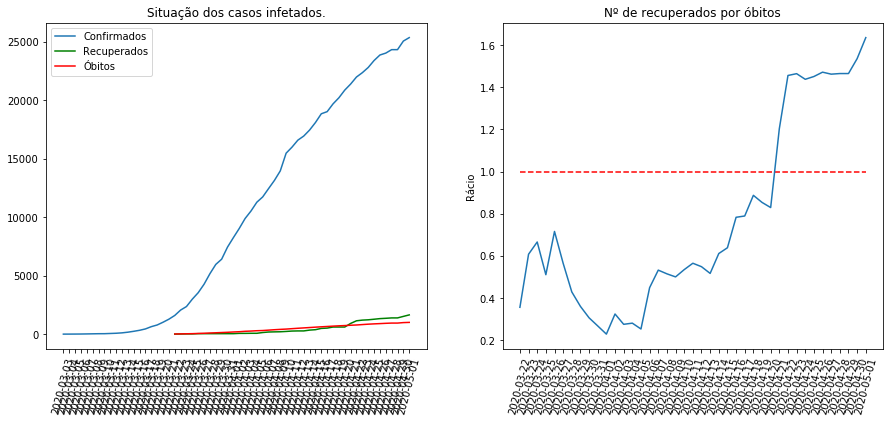

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

dates = df['data_relatorio'].to_numpy()
recuperados = df['recuperados'].to_numpy()
obitos = df['obitos'].to_numpy()
confirmados = df['confirmados'].to_numpy()

start = 0
for i in range(0, dates.size):
    if obitos[i] > 0 and recuperados[i] > 0:
        start = i
        break

ratio = recuperados[start:] / obitos[start:]

fig, (sub1, sub2) = plt.subplots(1, 2,figsize=(15,6))

sub1.set_title("Situação dos casos infetados.")
sub1.plot(dates, confirmados)
sub1.plot(dates[start:], recuperados[start:], 'g')
sub1.plot(dates[start:], obitos[start:], 'r')
sub1.legend(['Confirmados', 'Recuperados', 'Óbitos'])
#sub1.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
#sub1.xaxis.set_major_locator(mdates.DayLocator(interval=5))
#fig.autofmt_xdate()

sub2.set_title("Nº de recuperados por óbitos")
sub2.plot(dates[start:], ratio)
sub2.hlines(1, dates[start], dates[dates.size - 1], linestyles='dashed', colors='red')
sub2.set(ylabel="Rácio")

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=75)

plt.show()

# Gráficos de pirâmides

O objetivo desta parte é representar os casos confirmados e óbitos por faixas etárias e género.

Para facilitar a criação do gráfico, instalei e importei o módulo `seaborn` que funciona com o `matplotlib`

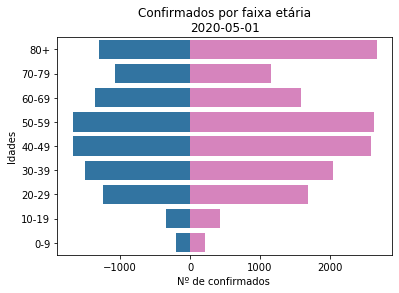

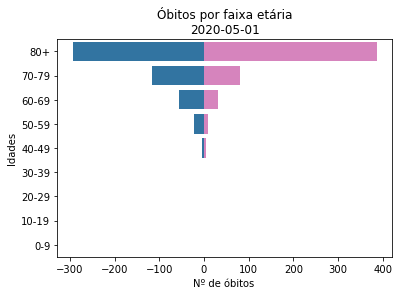

In [4]:
import seaborn as sns
import re

columns = df.columns

age_groups = []
obitos_columns_m = []
obitos_columns_f = []
confirmados_columns_m = []
confirmados_columns_f = []

for c in columns:
    if re.match(r'obitos_masculino', c):
        obitos_columns_m.append(c)
        s, f = re.findall(r'obitos_masculino_([0-9]+)_([0-9]+|sup)', c)[0]
        if f == 'sup':
            age_groups.append(f'{s}+')
        else:
            age_groups.append(f'{s}-{f}')
    if re.match(r'obitos_feminino', c):
        obitos_columns_f.append(c)
    if re.match(r'confirmados_masculino', c):
        confirmados_columns_m.append(c)
    if re.match(r'confirmados_feminino', c):
        confirmados_columns_f.append(c)

obitos_m = []
obitos_f = []
confirmados_m = []
confirmados_f = []
for i in range(len(age_groups) - 1, -1, -1):
    obitos_m.append(int(0 - df[obitos_columns_m[i]][dates.size]))
    obitos_f.append(int(    df[obitos_columns_f[i]][dates.size]))
    confirmados_m.append(int(0 - df[confirmados_columns_m[i]][dates.size]))
    confirmados_f.append(int(    df[confirmados_columns_f[i]][dates.size]))
    
reverse = age_groups.reverse()
#fig2, (pyramid_plot1, pyramid_plot2) = plt.subplots(1, 2,figsize=(15,6))

pyramid_plot1 = sns.barplot(x=confirmados_m, y=age_groups, order=reverse, color='tab:blue')
pyramid_plot1 = sns.barplot(x=confirmados_f, y=age_groups, order=reverse, color='tab:pink')
pyramid_plot1.set(xlabel="Nº de confirmados ", ylabel="Idades", 
                  title = "Confirmados por faixa etária\n" + dates[dates.size-1])
                  #rc={'figure.figsize':(6,6)})
plt.show()

pyramid_plot2 = sns.barplot(x=obitos_m, y=age_groups, order=reverse, color='tab:blue')
pyramid_plot2 = sns.barplot(x=obitos_f, y=age_groups, order=reverse, color='tab:pink')
pyramid_plot2.set(xlabel="Nº de óbitos ", ylabel="Idades",
                  title = "Óbitos por faixa etária\n" + dates[dates.size-1])
                  #rc={'figure.figsize':(6,6)})
plt.show()


# Mapas

In [5]:
dfw = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/04-30-2020.csv")

In [6]:
dfw.tail()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
3172,NaN,NaN,NaN,West Bank and Gaza,2020-05-01 02:32:28,31.952200,35.233200,344,2,76,266,West Bank and Gaza
3173,NaN,NaN,NaN,Western Sahara,2020-05-01 02:32:28,24.215500,-12.885800,6,0,5,1,Western Sahara
3174,NaN,NaN,NaN,Yemen,2020-05-01 02:32:28,15.552727,48.516388,6,2,1,3,Yemen
3175,NaN,NaN,NaN,Zambia,2020-05-01 02:32:28,-13.133897,27.849332,106,3,55,48,Zambia
3176,NaN,NaN,NaN,Zimbabwe,2020-05-01 02:32:28,-19.015438,29.154857,40,4,5,31,Zimbabwe


In [7]:
from IPython.display import Image

In [8]:
world_gpkg = "world_map.gpkg"
conn = ogr.Open(world_gpkg)
for i in conn:
    vlayer = QgsVectorLayer("{}|layername={}".format(world_gpkg, i.GetName()), i.GetName(), "ogr")
    if not vlayer.isValid():
        print("Layer {} failed to load".format(i.GetName()))
    else:
        QgsProject.instance().addMapLayer(vlayer)
        print("Layer {} loaded".format(i.GetName()))
        
world = QgsProject.instance().mapLayersByName('world_map')[0]
cases = QgsProject.instance().mapLayersByName('cases')[0]

print(world.fields().names())
print(cases.fields().names())

Layer world_map loaded
Layer cases loaded
['fid', 'featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3', 'ADM0_DIF', 'LEVEL', 'TYPE', 'ADMIN', 'ADM0_A3', 'GEOU_DIF', 'GEOUNIT', 'GU_A3', 'SU_DIF', 'SUBUNIT', 'SU_A3', 'BRK_DIFF', 'NAME', 'NAME_LONG', 'BRK_A3', 'BRK_NAME', 'BRK_GROUP', 'ABBREV', 'POSTAL', 'FORMAL_EN', 'FORMAL_FR', 'NAME_CIAWF', 'NOTE_ADM0', 'NOTE_BRK', 'NAME_SORT', 'NAME_ALT', 'MAPCOLOR7', 'MAPCOLOR8', 'MAPCOLOR9', 'MAPCOLOR13', 'POP_EST', 'POP_RANK', 'GDP_MD_EST', 'POP_YEAR', 'LASTCENSUS', 'GDP_YEAR', 'ECONOMY', 'INCOME_GRP', 'WIKIPEDIA', 'FIPS_10_', 'ISO_A2', 'ISO_A3', 'ISO_A3_EH', 'ISO_N3', 'UN_A3', 'WB_A2', 'WB_A3', 'WOE_ID', 'WOE_ID_EH', 'WOE_NOTE', 'ADM0_A3_IS', 'ADM0_A3_US', 'ADM0_A3_UN', 'ADM0_A3_WB', 'CONTINENT', 'REGION_UN', 'SUBREGION', 'REGION_WB', 'NAME_LEN', 'LONG_LEN', 'ABBREV_LEN', 'TINY', 'HOMEPART', 'MIN_ZOOM', 'MIN_LABEL', 'MAX_LABEL', 'NE_ID', 'WIKIDATAID', 'NAME_AR', 'NAME_BN', 'NAME_DE', 'NAME_EN', 'NAME_ES', 'NAME_FR', 'NAME_EL', 'NAME_HI',

In [9]:
#joinObject = QgsVectorLayerJoinInfo()
#joinObject.setJoinLayer(cases)
#joinObject.setJoinLayerId(cases.id())
#joinObject.setJoinFieldName('Country_Region')
#joinObject.setTargetFieldName('NAME_EN')
#joinObject.memoryCache = True
#print(joinObject.joinLayer())
#world.addJoin(joinObject)

worldField='NAME_EN'
casesField='Country_Region'
joinObject = QgsVectorLayerJoinInfo()
joinObject.joinLayerId = cases.id()
joinObject.joinFieldName = casesField
joinObject.targetFieldName = worldField
joinObject.memoryCache = True
world.addJoin(joinObject)

print(world.fields().names())
#print(cases.fields().names())

['fid', 'featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3', 'ADM0_DIF', 'LEVEL', 'TYPE', 'ADMIN', 'ADM0_A3', 'GEOU_DIF', 'GEOUNIT', 'GU_A3', 'SU_DIF', 'SUBUNIT', 'SU_A3', 'BRK_DIFF', 'NAME', 'NAME_LONG', 'BRK_A3', 'BRK_NAME', 'BRK_GROUP', 'ABBREV', 'POSTAL', 'FORMAL_EN', 'FORMAL_FR', 'NAME_CIAWF', 'NOTE_ADM0', 'NOTE_BRK', 'NAME_SORT', 'NAME_ALT', 'MAPCOLOR7', 'MAPCOLOR8', 'MAPCOLOR9', 'MAPCOLOR13', 'POP_EST', 'POP_RANK', 'GDP_MD_EST', 'POP_YEAR', 'LASTCENSUS', 'GDP_YEAR', 'ECONOMY', 'INCOME_GRP', 'WIKIPEDIA', 'FIPS_10_', 'ISO_A2', 'ISO_A3', 'ISO_A3_EH', 'ISO_N3', 'UN_A3', 'WB_A2', 'WB_A3', 'WOE_ID', 'WOE_ID_EH', 'WOE_NOTE', 'ADM0_A3_IS', 'ADM0_A3_US', 'ADM0_A3_UN', 'ADM0_A3_WB', 'CONTINENT', 'REGION_UN', 'SUBREGION', 'REGION_WB', 'NAME_LEN', 'LONG_LEN', 'ABBREV_LEN', 'TINY', 'HOMEPART', 'MIN_ZOOM', 'MIN_LABEL', 'MAX_LABEL', 'NE_ID', 'WIKIDATAID', 'NAME_AR', 'NAME_BN', 'NAME_DE', 'NAME_EN', 'NAME_ES', 'NAME_FR', 'NAME_EL', 'NAME_HI', 'NAME_HU', 'NAME_ID', 'NAME_IT', 'NAME_JA

In [10]:
vals = []
#fld = 'fid'
#for f in world.getFeatures():
#    vals.append(f[fld])
    
#colors = ['#ff0004', '#e1f3b3', '#c8e99e', '#a9dc8e', '#88cd80', '#68be71', '#48af60', '#2b9d51', '#158244' '#006837']
#lower = sorted(vals)[0]
#upper = sorted(vals)[-1]
#step = (upper-lower)/len(colors)
#range_list = []
#for c in colors:
#    cat = [lower, lower+step, c]
#    sym = QgsSymbol.defaultSymbol(world.geometryType())
#    sym.setColor(QColor(cat[2]))
#    rng = QgsRendererRange(cat[0], cat[1], sym, '{0:.1f}-{1:.1f}'.format(cat[0], cat[1]))
#    range_list.append(rng)
#    lower = (lower+step)+0.1
#renderer = QgsGraduatedSymbolRenderer()
#world.setRenderer(renderer)
#world.triggerRepaint()

In [11]:
xt = world.extent()
print(xt)
width  = 1000
height = int(width*xt.height()/xt.width())
print("Gerar mapa com {} por {}".format(width, height))

#expression =  QgsExpression('"04-30-2020_Recovered" / "04-30-2020_Deaths"')
#context = QgsExpressionContext()
#context.appendScopes(QgsExpressionContextUtils.globalProjectLayerScopes(world))

#with edit(world):
#    for f in world.getFeatures():
#        context.setFeature(f)
        #f.add('04-30-2020_Recovered"  /  "04-30-2020_Deaths', expression.evaluate(context))
#        f['LABELRANK'] = expression.evaluate(context)
#        world.updateFeature(f)

options = QgsMapSettings()
options.setLayers([world])
options.setBackgroundColor(QColor(255, 255, 255))
options.setOutputSize(QSize(width, height))
options.setExtent(xt)
#options.setExpressionContext(context)
           
render = QgsMapRendererParallelJob(options)
render.start()
render.waitForFinished()

image = render.renderedImage()

<QgsRectangle: -180 -90, 180 83.63410065300010388>
Gerar mapa com 1000 por 482


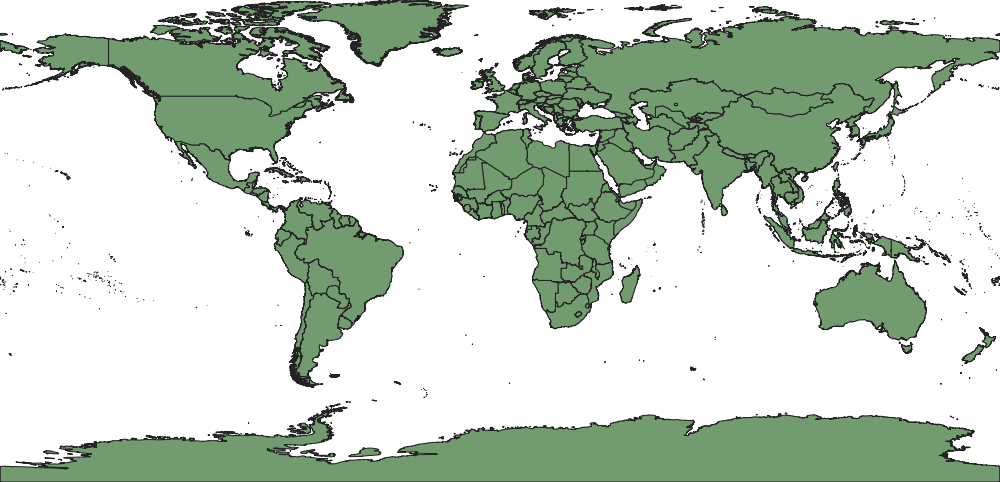

In [12]:
imgbuf= QBuffer()
imgbuf.open( QIODevice.ReadWrite )
image.save( imgbuf,"PNG" )
Image( imgbuf.data() )

# Problemas

O objetivo neste mapa era mostrar o rácio de recuperados por óbitos como num dos gráficos anteriores, no entanto não o consegui fazer. 

Tive problemas a fazer join das duas tabelas quando acho que tudo está bem mesmo pelo que vi na internet. Resolvi juntá-las no QGIS e daí os resultados neste notebook mostrarem as tabelas juntas mas tive problemas em criar a imagem com uma expressão que seria o número de recuperados a dividir pelo número de óbitos.

O resultado pretendido era o seguinte que foi feito no QGIS com a interface visual:

![alt text](map.png "map")

Alguns países não aparecem por cause de serem representados no .csv por estados/províncias. O plano era com o pandas tratar esses dados de forma a uniformizar, mas não consegui arranjar maneira de incorporar os dataframes do pandas com o qgis.